# Constructing VLE Diagrams using Equation of State Methods

Teng-Jui Lin

Content adapted from UW CHEME 326, Chemical Engineering Thermodynamics, in Winter 2022.

Problems reprinted from Koretsky, M. D. *Engineering and Chemical Thermodynamics*. (Wiley, 2012).

## Comparison of vdW and Peng-Robinson EOS for predicting VLE behavior

**Koretsky Example 8.17.** The following data are available for vapor–liquid equilibrium of the methane (1) n-pentane (2) binary system at 37.78°C. Compare how well the van der Waals and Peng–Robinson equations can represent these data using the equation of state method to calculate fugacity coefficients of the vapor and the liquid.

```python
P_truth = np.array([13.82, 27.68, 41.45, 55.26, 69.08, 86.35, 103.62, 120.89, 138.16, 155.43, 172.70]) * 1e5 # bar to Pa
y1_truth = np.array([0.8954, 0.9322, 0.9422, 0.9486, 0.9494, 0.9483, 0.9421, 0.9296, 0.9128, 0.889, 0.849])
x1_truth = np.array([0.0646, 0.1293, 0.1892, 0.2453, 0.2965, 0.3565, 0.4152, 0.4782, 0.5509, 0.635, 0.735])
```


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy import optimize
from sympy import Symbol
from sympy.solvers import solve

In [2]:
# plot settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams.update(
    {
        "font.family": "Arial",  # Times New Roman, Calibri
        "font.weight": "normal",
        "mathtext.fontset": "cm",
        "font.size": 18,
        "lines.linewidth": 2,
        "axes.linewidth": 2,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titleweight": "bold",
        "axes.titlesize": 18,
        "axes.labelweight": "bold",
        "xtick.major.size": 8,
        "xtick.major.width": 2,
        "ytick.major.size": 8,
        "ytick.major.width": 2,
        "figure.dpi": 80,
        "legend.framealpha": 1,
        "legend.edgecolor": "black",
        "legend.fancybox": False,
        "legend.fontsize": 14,
    }
)

In [3]:
# given data
P_truth = np.array([13.82, 27.68, 41.45, 55.26, 69.08, 86.35, 103.62, 120.89, 138.16, 155.43, 172.70]) * 1e5 # bar to Pa
y1_truth = np.array([0.8954, 0.9322, 0.9422, 0.9486, 0.9494, 0.9483, 0.9421, 0.9296, 0.9128, 0.889, 0.849])
x1_truth = np.array([0.0646, 0.1293, 0.1892, 0.2453, 0.2965, 0.3565, 0.4152, 0.4782, 0.5509, 0.635, 0.735])

In [4]:
# liquid compositions to be simulated
x1_sim = np.arange(0.001, 1, 0.005)
x2_sim = 1 - x1_sim

### vdW EOS

In [5]:
# universal constant
R = 8.314  # J/mol K
# given properties
T = 37.78 + 273.15  # K

# formula for vdW params and saturation pressure
pure_a = lambda Tc, Pc, R: 27 / 64 * (R * Tc) ** 2 / Pc
pure_b = lambda Tc, Pc, R: 1 / 8 * (R * Tc) / Pc
antoine = lambda A, B, C, T: np.exp(A - B / (T + C)) * 1e5  # Pa

# physical properties - appendix a1
# methane (1)
A1 = 8.6041
B1 = 897.84
C1 = -7.16
Tc1 = 190.6  # K
Pc1 = 46.00e5  # Pa
a1 = pure_a(Tc1, Pc1, R)
b1 = pure_b(Tc1, Pc1, R)
# n-pentane (2)
A2 = 9.2131
B2 = 2477.07
C2 = -39.94
Tc2 = 469.6  # K
Pc2 = 33.74e5  # Pa
a2 = pure_a(Tc2, Pc2, R)
b2 = pure_b(Tc2, Pc2, R)
# mixture
a12 = np.sqrt(a1 * a2)

# saturation pressures
Psat1 = antoine(A1, B1, C1, T)
Psat2 = antoine(A2, B2, C2, T)

In [6]:
def solve_v(T, P, a, b, R, v_before, threshold=1e-10):
    """Solve vdW EOS for v."""
    coeff = [-a * b, a, -(R * T + P * b), P]
    # solve for compressibility factor
    v = np.polynomial.polynomial.polyroots(coeff)
    # z is real and positive
    v = np.real(v)
    v = v[v > 0]
    # double check if solution is good in case of algorithmic instability
    error = np.abs(np.polynomial.polynomial.polyval(v, coeff))
    v = v[error < threshold]
    # use the root closest to the last v
    closest_idx = np.argmin(np.abs(v - v_before))
    v = v[closest_idx]
    return v

In [7]:
# formula for mixed vdW params
mixed_a = (
    lambda comp1, comp2, a1, a2: comp1**2 * a1
    + 2 * comp1 * comp2 * np.sqrt(a1 * a2)
    + comp2**2 * a2
)
mixed_b = lambda comp1, comp2, b1, b2: comp1 * b1 + comp2 * b2

# formula for fugacity coefficients (phi_1, for phi_2, switch arguments of 1 and 2 properties)
phi = lambda comp1, comp2, P, v, T, R, a1, a12, b, b1: np.exp(
    b1 / (v - b)
    - np.log((v - b) * P / (R * T))
    - 2 * (comp1 * a1 + comp2 * a12) / (R * T * v)
)

In [8]:
vdw_a_v = []
vdw_b_v = []
vdw_P = []
vdw_y1 = []
vdw_y2 = []
vdw_v_v = []
vdw_v_l = []
vdw_phi_v1 = []
vdw_phi_v2 = []
vdw_phi_l1 = []
vdw_phi_l2 = []
v_v = 0
v_l = 0

for i in range(len(x1_sim)):
    # assign current liquid composition
    x1 = x1_sim[i]
    x2 = x2_sim[i]
    # estimate total pressure
    P = x1 * Psat1 + x2 * Psat2
    # estimate vapor compositions
    y1 = x1 * Psat1 / P
    y2 = x2 * Psat2 / P

    # iteratre through vdW EOS
    num_iter = 0
    max_iter = 10000
    tol = 0.001
    tol_criteria = tol * 2
    while tol_criteria > tol and num_iter < max_iter:
        # calculate vdW parameters for mixtures in each phase
        a_v = mixed_a(y1, y2, a1, a2)
        b_v = mixed_b(y1, y2, b1, b2)
        a_l = mixed_a(x1, x2, a1, a2)
        b_l = mixed_b(x1, x2, b1, b2)
        # solve vdW EOS for molar volume in each phase
        v_v = solve_v(T, P, a_v, b_v, R, v_before=v_v)
        v_l = solve_v(T, P, a_l, b_l, R, v_before=v_l)
        # print(i, num_iter, a_v, b_v, P)
        # print(i, num_iter, a_l, b_l, P)
        # print(i, num_iter, v_v, v_l)
        # calculate fugacity coefficient of each species in each phase
        phi_v1 = phi(y1, y2, P, v_v, T, R, a1, a12, b_v, b1)
        phi_v2 = phi(y2, y1, P, v_v, T, R, a2, a12, b_v, b2)
        phi_l1 = phi(x1, x2, P, v_l, T, R, a1, a12, b_l, b1)
        phi_l2 = phi(x2, x1, P, v_l, T, R, a2, a12, b_l, b2)
        # update vapor composition
        y1 = x1 * phi_l1 / phi_v1
        y2 = x2 * phi_l2 / phi_v2
        # update total pressure
        P = P * (y1 + y2)
        # calculate if calculation converges
        tol_criteria = abs(y1 + y2 - 1)
        num_iter += 1
    # store computed results
    vdw_a_v.append(a_v)
    vdw_b_v.append(b_v)
    vdw_v_v.append(v_v)
    vdw_v_l.append(v_l)
    vdw_phi_v1.append(phi_v1)
    vdw_phi_v2.append(phi_v2)
    vdw_phi_l1.append(phi_l1)
    vdw_phi_l2.append(phi_l2)
    vdw_y1.append(y1)
    vdw_y2.append(y2)
    vdw_P.append(P)

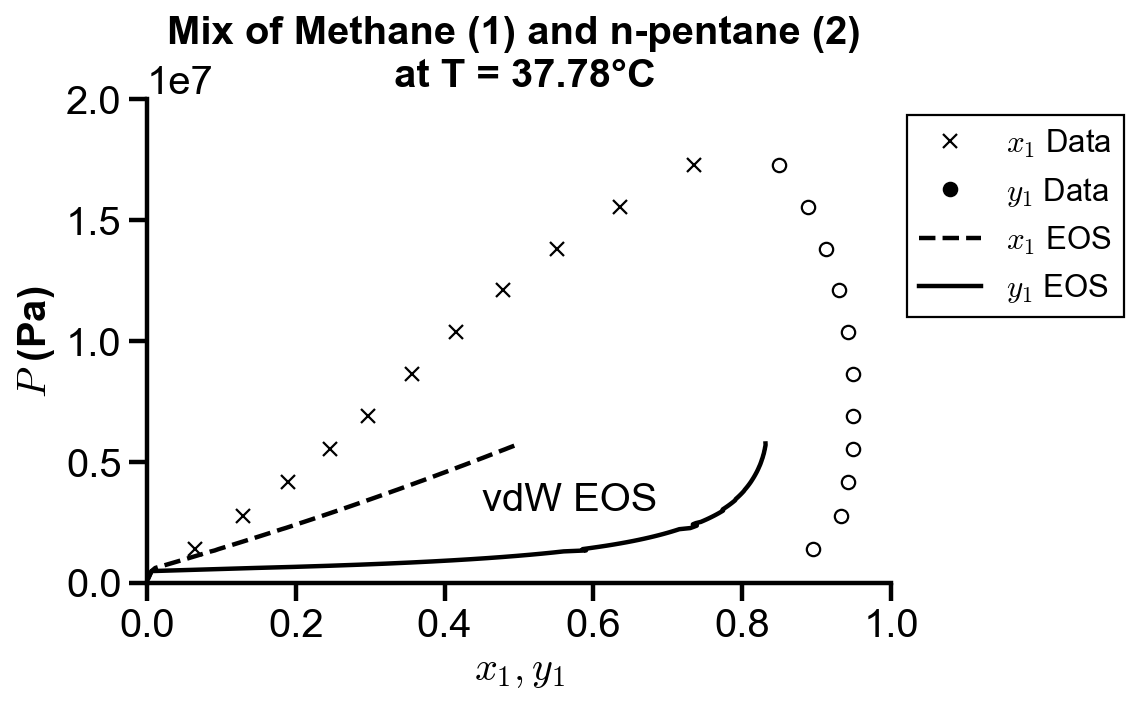

In [9]:
fig, ax = plt.subplots()

# plot raw data
ax.plot(x1_truth, P_truth, "kx")
ax.plot(y1_truth, P_truth, "ko", mfc="none")
# plot vdW simulated data
vdw_range_idx = 101
ax.plot(x1_sim[:vdw_range_idx], vdw_P[:vdw_range_idx], "k--")
ax.plot(vdw_y1[:vdw_range_idx], vdw_P[:vdw_range_idx], "k-")
ax.text(0.45, 0.3e7, "vdW EOS")
# plot settings
ax.set_xlim(0, 1)
ax.set_ylim(0, 200e5)
ax.set_xlabel("$x_1, y_1$")
ax.set_ylabel("$P$ (Pa)")
ax.set_title("Mix of Methane (1) and n-pentane (2) \n at T = 37.78°C")

# custom legend
legend_elements = [
    Line2D([0], [0], marker="x", ls="none", color="k", label="$x_1$ Data"),
    Line2D([0], [0], marker="o", ls="none", color="k", label="$y_1$ Data"),
    Line2D([0], [0], ls="--", color="k", label="$x_1$ EOS"),
    Line2D([0], [0], ls="-", color="k", label="$y_1$ EOS"),
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1))

## Peng-Robinson EOS

In [10]:
# universal constant
R = 8.314  # J/mol K
# given properties
T = 37.78 + 273.15  # K

# formula for Peng-Robinson params and saturation pressure
pure_a = lambda Tc, Pc, R: 0.45724 * (R * Tc) ** 2 / Pc
pure_b = lambda Tc, Pc, R: 0.07780 * (R * Tc) / Pc
kappa = lambda omega: 0.37464 + 1.54226 * omega - 0.26992 * omega**2
alpha = lambda Tr, kappa: (1 + kappa * (1 - np.sqrt(Tr))) ** 2
antoine = lambda A, B, C, T: np.exp(A - B / (T + C)) * 1e5  # Pa

# physical properties - appendix a1
# methane (1)
A1 = 8.6041
B1 = 897.84
C1 = -7.16
omega1 = 0.008
Tc1 = 190.6  # K
Pc1 = 46.00e5  # Pa
Tr1 = T / Tc1
a1 = pure_a(Tc1, Pc1, R)
b1 = pure_b(Tc1, Pc1, R)
kappa1 = kappa(omega1)
alpha1 = alpha(Tr1, kappa1)
a_alpha_1 = a1 * alpha1
# n-pentane (2)
A2 = 9.2131
B2 = 2477.07
C2 = -39.94
omega2 = 0.251
Tc2 = 469.6  # K
Pc2 = 33.74e5  # Pa
Tr2 = T / Tc2
a2 = pure_a(Tc2, Pc2, R)
b2 = pure_b(Tc2, Pc2, R)
kappa2 = kappa(omega2)
alpha2 = alpha(Tr2, kappa2)
a_alpha_2 = a2 * alpha2
# mixture
k12 = 0
a12 = np.sqrt(a1 * a2)
a_alpha_12 = np.sqrt(a_alpha_1 * a_alpha_2)

# saturation pressures
Psat1 = antoine(A1, B1, C1, T)
Psat2 = antoine(A2, B2, C2, T)

In [11]:
def solve_v(T, P, a_alpha, b, R, v_before, threshold=1e-10):
    """Solve Peng-Robinson EOS for v."""
    A = a_alpha * P / (R * T) ** 2
    B = b * P / (R * T)
    coeff = [-(A * B - B**2 - B**3), A - 2 * B - 3 * B**2, -(1 - B), 1]
    # solve for compressibility factor
    z = np.polynomial.polynomial.polyroots(coeff)
    # z is real and positive
    z = np.real(z)
    z = z[z > 0]
    # double check if solution is good in case of algorithmic instability
    error = np.abs(np.polynomial.polynomial.polyval(z, coeff))
    z = z[error < threshold]
    # convert to v
    v = z * R * T / P
    v = v[v > b]
    # use the root closest to the last v
    closest_idx = np.argmin(np.abs(v - v_before))
    v = v[closest_idx]
    return v

In [12]:
# formula for mixed Peng-Robinson params
mixed_a_alpha = (
    lambda comp1, comp2, a_alpha_1, a_alpha_2, k12: comp1**2 * a_alpha_1
    + 2 * comp1 * comp2 * np.sqrt(a_alpha_1 * a_alpha_2) * (1 - k12)
    + comp2**2 * a_alpha_2
)
mixed_b = lambda comp1, comp2, b1, b2: comp1 * b1 + comp2 * b2

# formula for fugacity coefficients (phi_1, for phi_2, switch arguments of 1 and 2 properties)
phi = lambda comp1, comp2, P, v, T, R, a_alpha, a_alpha_1, a_alpha_12, b, b1: np.exp(
    b1 / b * (P * v / (R * T) - 1)
    - np.log((v - b) * P / (R * T))
    + a_alpha
    / (2 * np.sqrt(2) * b * R * T)
    * (b1 / b - 2 / a_alpha * (comp1 * a_alpha_1 + comp2 * a_alpha_12))
    * np.log((v + (1 + np.sqrt(2)) * b) / (v + (1 - np.sqrt(2)) * b))
)

In [13]:
# initialize guess
v_v = 0
v_l = 0
# generate lists to store iteration results
pr_a_alpha_v = []
pr_b_v = []
pr_P = []
pr_y1 = []
pr_y2 = []
pr_v_v = []
pr_v_l = []
pr_phi_v1 = []
pr_phi_v2 = []
pr_phi_l1 = []
pr_phi_l2 = []

for i in range(len(x1_sim)):
    # assign current liquid composition
    x1 = x1_sim[i]
    x2 = x2_sim[i]
    # estimate total pressure
    P = x1 * Psat1 + x2 * Psat2
    # estimate vapor compositions
    y1 = x1 * Psat1 / P
    y2 = x2 * Psat2 / P

    # iteratre through Peng-Robinson EOS
    num_iter = 0
    max_iter = 10000
    tol = 0.001
    tol_criteria = tol * 2
    while tol_criteria > tol and num_iter < max_iter:
        # calculate Peng-Robinson parameters for mixtures in each phase
        a_alpha_v = mixed_a_alpha(y1, y2, a_alpha_1, a_alpha_2, k12)
        b_v = mixed_b(y1, y2, b1, b2)
        a_alpha_l = mixed_a_alpha(x1, x2, a_alpha_1, a_alpha_2, k12)
        b_l = mixed_b(x1, x2, b1, b2)
        # solve Peng-Robinson EOS for molar volume in each phase
        v_v = solve_v(T, P, a_alpha_v, b_v, R, v_before=v_v)
        v_l = solve_v(T, P, a_alpha_l, b_l, R, v_before=v_l)
        # print(i, num_iter, v_v, v_l)
        # calculate fugacity coefficient of each species in each phase
        phi_v1 = phi(y1, y2, P, v_v, T, R, a_alpha_v, a_alpha_1, a_alpha_12, b_v, b1)
        phi_v2 = phi(y2, y1, P, v_v, T, R, a_alpha_v, a_alpha_2, a_alpha_12, b_v, b2)
        phi_l1 = phi(x1, x2, P, v_l, T, R, a_alpha_l, a_alpha_1, a_alpha_12, b_l, b1)
        phi_l2 = phi(x2, x1, P, v_l, T, R, a_alpha_l, a_alpha_2, a_alpha_12, b_l, b2)
        # update vapor composition
        y1 = x1 * phi_l1 / phi_v1
        y2 = x2 * phi_l2 / phi_v2
        # update total pressure
        P = P * (y1 + y2)
        # print(phi_v1, phi_v2, phi_l1, phi_l2)
        # print(y1, y2, P)
        # calculate if calculation converges
        tol_criteria = abs(y1 + y2 - 1)
        num_iter += 1
    # store computed results
    pr_a_alpha_v.append(a_alpha_v)
    pr_b_v.append(b_v)
    pr_v_v.append(v_v)
    pr_v_l.append(v_l)
    pr_phi_v1.append(phi_v1)
    pr_phi_v2.append(phi_v2)
    pr_phi_l1.append(phi_l1)
    pr_phi_l2.append(phi_l2)
    pr_y1.append(y1)
    pr_y2.append(y2)
    pr_P.append(P)

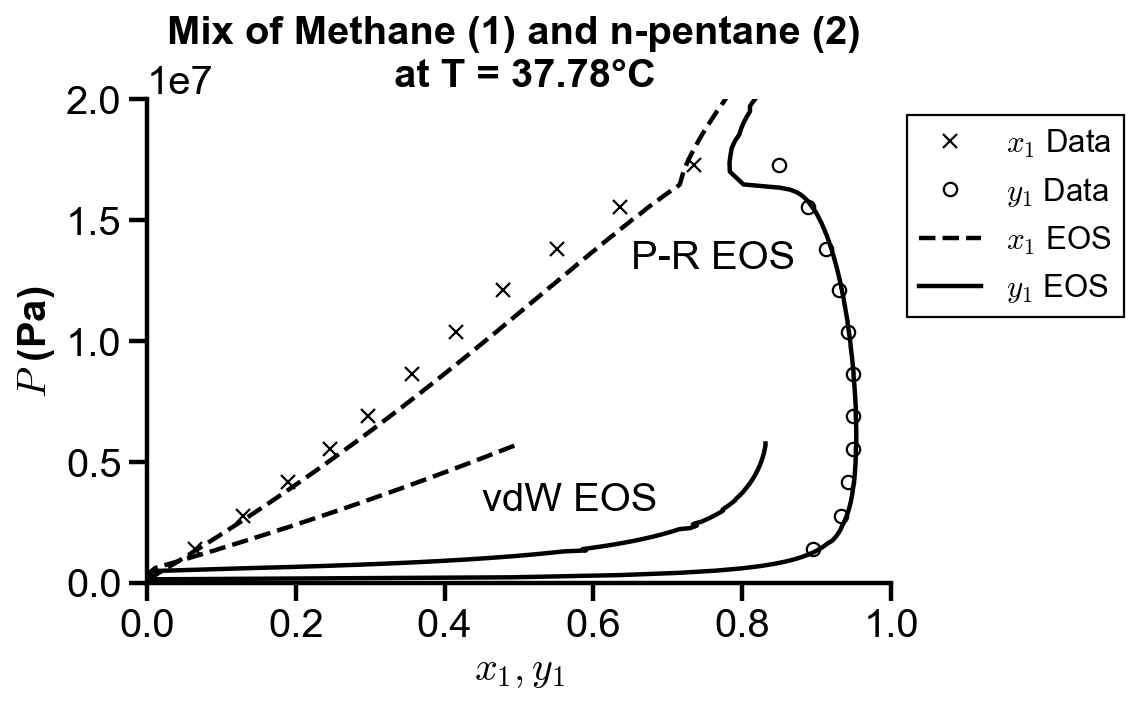

In [14]:
fig, ax = plt.subplots()

# plot raw data
ax.plot(x1_truth, P_truth, "kx")
ax.plot(y1_truth, P_truth, "ko", mfc="none")
# plot vdW simulated data
vdw_range_idx = 101
ax.plot(x1_sim[:vdw_range_idx], vdw_P[:vdw_range_idx], "k--")
ax.plot(vdw_y1[:vdw_range_idx], vdw_P[:vdw_range_idx], "k-")
ax.text(0.45, 0.3e7, "vdW EOS")
# plot Peng-Robinson simulated data
pr_range_idx = 161
ax.plot(x1_sim[:pr_range_idx], pr_P[:pr_range_idx], "k--")
ax.plot(pr_y1[:pr_range_idx], pr_P[:pr_range_idx], "k-")
ax.text(0.65, 1.3e7, "P-R EOS")

# plot settings
ax.set_xlim(0, 1)
ax.set_ylim(0, 200e5)
ax.set_xlabel("$x_1, y_1$")
ax.set_ylabel("$P$ (Pa)")
ax.set_title("Mix of Methane (1) and n-pentane (2) \n at T = 37.78°C")

# custom legend
legend_elements = [
    Line2D([0], [0], marker="x", ls="none", color="k", label="$x_1$ Data"),
    Line2D([0], [0], marker="o", mfc='none', ls="none", color="k", label="$y_1$ Data"),
    Line2D([0], [0], ls="--", color="k", label="$x_1$ EOS"),
    Line2D([0], [0], ls="-", color="k", label="$y_1$ EOS"),
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1))

## Effect of binary interaction parameter $k_{12}$ on the Predictions of Peng-Robinson EOS

**Koretsky Example 8.18.** Repeat Example 8.17 for the Peng–Robinson equation with values of the binary interaction parameter, $k_{12}$ of 0.025, 0.05, and 0.10.

In [15]:
# binary interaction parameters to simulate
k12_sim = np.array([0, 0.025, 0.05, 0.1, 1])

In [16]:
# universal constant
R = 8.314  # J/mol K
# given properties
T = 37.78 + 273.15  # K

# formula for Peng-Robinson params and saturation pressure
pure_a = lambda Tc, Pc, R: 0.45724 * (R * Tc) ** 2 / Pc
pure_b = lambda Tc, Pc, R: 0.07780 * (R * Tc) / Pc
kappa = lambda omega: 0.37464 + 1.54226 * omega - 0.26992 * omega**2
alpha = lambda Tr, kappa: (1 + kappa * (1 - np.sqrt(Tr))) ** 2
antoine = lambda A, B, C, T: np.exp(A - B / (T + C)) * 1e5  # Pa

# physical properties - appendix a1
# methane (1)
A1 = 8.6041
B1 = 897.84
C1 = -7.16
omega1 = 0.008
Tc1 = 190.6  # K
Pc1 = 46.00e5  # Pa
Tr1 = T / Tc1
a1 = pure_a(Tc1, Pc1, R)
b1 = pure_b(Tc1, Pc1, R)
kappa1 = kappa(omega1)
alpha1 = alpha(Tr1, kappa1)
a_alpha_1 = a1 * alpha1
# n-pentane (2)
A2 = 9.2131
B2 = 2477.07
C2 = -39.94
omega2 = 0.251
Tc2 = 469.6  # K
Pc2 = 33.74e5  # Pa
Tr2 = T / Tc2
a2 = pure_a(Tc2, Pc2, R)
b2 = pure_b(Tc2, Pc2, R)
kappa2 = kappa(omega2)
alpha2 = alpha(Tr2, kappa2)
a_alpha_2 = a2 * alpha2
# mixture
a12 = np.sqrt(a1 * a2)
a_alpha_12 = np.sqrt(a_alpha_1 * a_alpha_2)

# saturation pressures
Psat1 = antoine(A1, B1, C1, T)
Psat2 = antoine(A2, B2, C2, T)

In [17]:
def solve_v(T, P, a_alpha, b, R, v_before, threshold=1e-10):
    """Solve Peng-Robinson EOS for v."""
    A = a_alpha * P / (R * T) ** 2
    B = b * P / (R * T)
    coeff = [-(A * B - B**2 - B**3), A - 2 * B - 3 * B**2, -(1 - B), 1]
    # solve for compressibility factor
    z = np.polynomial.polynomial.polyroots(coeff)
    # z is real and positive
    z = np.real(z)
    z = z[z > 0]
    # double check if solution is good in case of algorithmic instability
    error = np.abs(np.polynomial.polynomial.polyval(z, coeff))
    z = z[error < threshold]
    # convert to v
    v = z * R * T / P
    v = v[v > b]
    # use the root closest to the last v
    closest_idx = np.argmin(np.abs(v - v_before))
    v = v[closest_idx]
    return v

In [18]:
# formula for mixed Peng-Robinson params
mixed_a_alpha = (
    lambda comp1, comp2, a_alpha_1, a_alpha_2, k12: comp1**2 * a_alpha_1
    + 2 * comp1 * comp2 * np.sqrt(a_alpha_1 * a_alpha_2) * (1 - k12)
    + comp2**2 * a_alpha_2
)
mixed_b = lambda comp1, comp2, b1, b2: comp1 * b1 + comp2 * b2

# formula for fugacity coefficients (phi_1, for phi_2, switch arguments of 1 and 2 properties)
phi = lambda comp1, comp2, P, v, T, R, a_alpha, a_alpha_1, a_alpha_12, b, b1: np.exp(
    b1 / b * (P * v / (R * T) - 1)
    - np.log((v - b) * P / (R * T))
    + a_alpha
    / (2 * np.sqrt(2) * b * R * T)
    * (b1 / b - 2 / a_alpha * (comp1 * a_alpha_1 + comp2 * a_alpha_12))
    * np.log((v + (1 + np.sqrt(2)) * b) / (v + (1 - np.sqrt(2)) * b))
)

In [19]:
pr_P = np.zeros((len(k12_sim), len(x1_sim)))
pr_y1 = np.zeros((len(k12_sim), len(x1_sim)))
pr_y2 = np.zeros((len(k12_sim), len(x1_sim)))
pr_v_v = np.zeros((len(k12_sim), len(x1_sim)))
pr_v_l = np.zeros((len(k12_sim), len(x1_sim)))
pr_phi_v1 = np.zeros((len(k12_sim), len(x1_sim)))
pr_phi_v2 = np.zeros((len(k12_sim), len(x1_sim)))
pr_phi_l1 = np.zeros((len(k12_sim), len(x1_sim)))
pr_phi_l2 = np.zeros((len(k12_sim), len(x1_sim)))

for j in range(len(k12_sim)):
    k12 = k12_sim[j]
    for i in range(len(x1_sim)):
        v_v = 0
        v_l = 0
        # assign current liquid composition
        x1 = x1_sim[i]
        x2 = x2_sim[i]
        # estimate total pressure
        P = x1 * Psat1 + x2 * Psat2
        # estimate vapor compositions
        y1 = x1 * Psat1 / P
        y2 = x2 * Psat2 / P

        # iteratre through Peng-Robinson EOS
        num_iter = 0
        max_iter = 10000
        tol = 0.001
        tol_criteria = tol * 2
        while tol_criteria > tol and num_iter < max_iter:
            # calculate Peng-Robinson parameters for mixtures in each phase
            a_alpha_v = mixed_a_alpha(y1, y2, a_alpha_1, a_alpha_2, k12)
            b_v = mixed_b(y1, y2, b1, b2)
            a_alpha_l = mixed_a_alpha(x1, x2, a_alpha_1, a_alpha_2, k12)
            b_l = mixed_b(x1, x2, b1, b2)
            # print(k12, i, num_iter, a_alpha_v, a_alpha_l)
            # solve Peng-Robinson EOS for molar volume in each phase
            v_v = solve_v(T, P, a_alpha_v, b_v, R, v_before=v_v)
            v_l = solve_v(T, P, a_alpha_l, b_l, R, v_before=v_l)
            # print(i, num_iter, v_v, v_l)
            # calculate fugacity coefficient of each species in each phase
            phi_v1 = phi(y1, y2, P, v_v, T, R, a_alpha_v, a_alpha_1, a_alpha_12, b_v, b1)
            phi_v2 = phi(y2, y1, P, v_v, T, R, a_alpha_v, a_alpha_2, a_alpha_12, b_v, b2)
            phi_l1 = phi(x1, x2, P, v_l, T, R, a_alpha_l, a_alpha_1, a_alpha_12, b_l, b1)
            phi_l2 = phi(x2, x1, P, v_l, T, R, a_alpha_l, a_alpha_2, a_alpha_12, b_l, b2)
            # update vapor composition
            y1 = x1 * phi_l1 / phi_v1
            y2 = x2 * phi_l2 / phi_v2
            # update total pressure
            P = P * (y1 + y2)
            # print(phi_v1, phi_v2, phi_l1, phi_l2)
            # print(y1, y2, P)
            # calculate if calculation converges
            tol_criteria = abs(y1 + y2 - 1)
            num_iter += 1
        # store computed results
        pr_P[j, i] = P
        pr_y1[j, i] = y1
        pr_y2[j, i] = y2
        pr_v_v[j, i] = v_v
        pr_v_l[j, i] = v_l
        pr_phi_v1[j, i] = phi_v1
        pr_phi_v2[j, i] = phi_v2
        pr_phi_l1[j, i] = phi_l1
        pr_phi_l2[j, i] = phi_l2

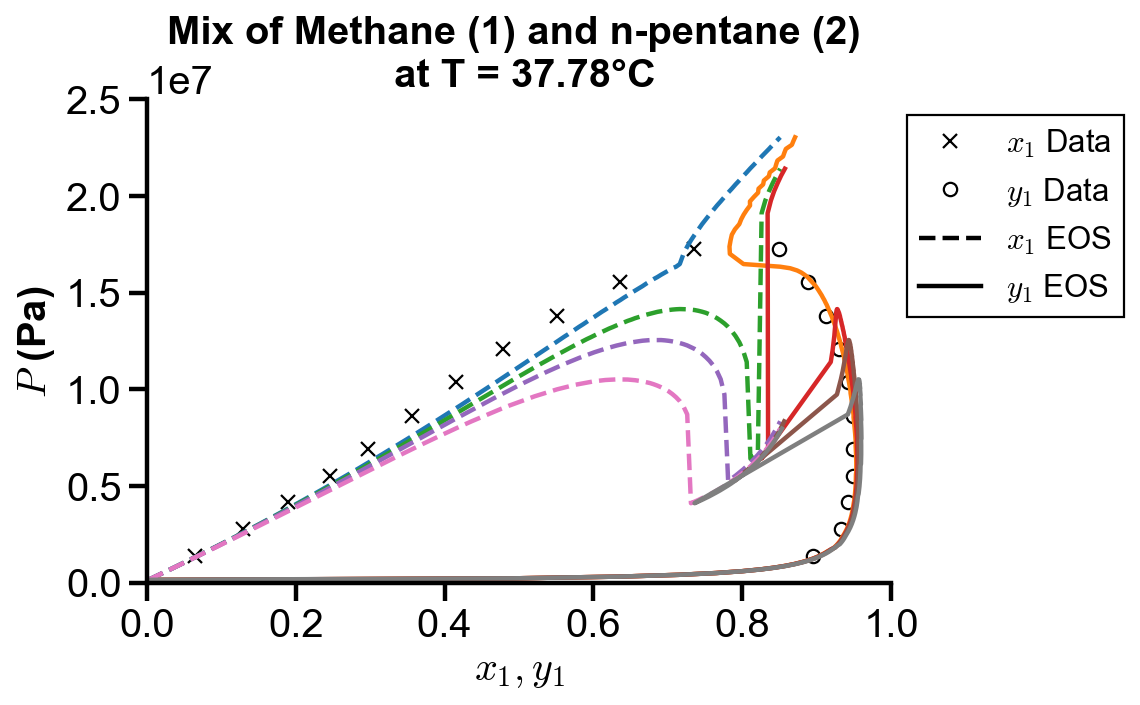

In [20]:
fig, ax = plt.subplots()

# plot raw data
ax.plot(x1_truth, P_truth, "kx")
ax.plot(y1_truth, P_truth, "ko", mfc="none")
# plot Peng-Robinson simulated data
pr_range_idx = 171 #141
for i in range(4):
    ax.plot(x1_sim[:pr_range_idx], pr_P[i, :pr_range_idx], "--")
    ax.plot(pr_y1[i, :pr_range_idx], pr_P[i, :pr_range_idx], "-")

# plot settings
ax.set_xlim(0, 1)
ax.set_ylim(0, 250e5)
ax.set_xlabel("$x_1, y_1$")
ax.set_ylabel("$P$ (Pa)")
ax.set_title("Mix of Methane (1) and n-pentane (2) \n at T = 37.78°C")

# custom legend
legend_elements = [
    Line2D([0], [0], marker="x", ls="none", color="k", label="$x_1$ Data"),
    Line2D([0], [0], marker="o", ls="none", mfc='none', color="k", label="$y_1$ Data"),
    Line2D([0], [0], ls="--", color="k", label="$x_1$ EOS"),
    Line2D([0], [0], ls="-", color="k", label="$y_1$ EOS"),
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1))

(0.0, 2.0)

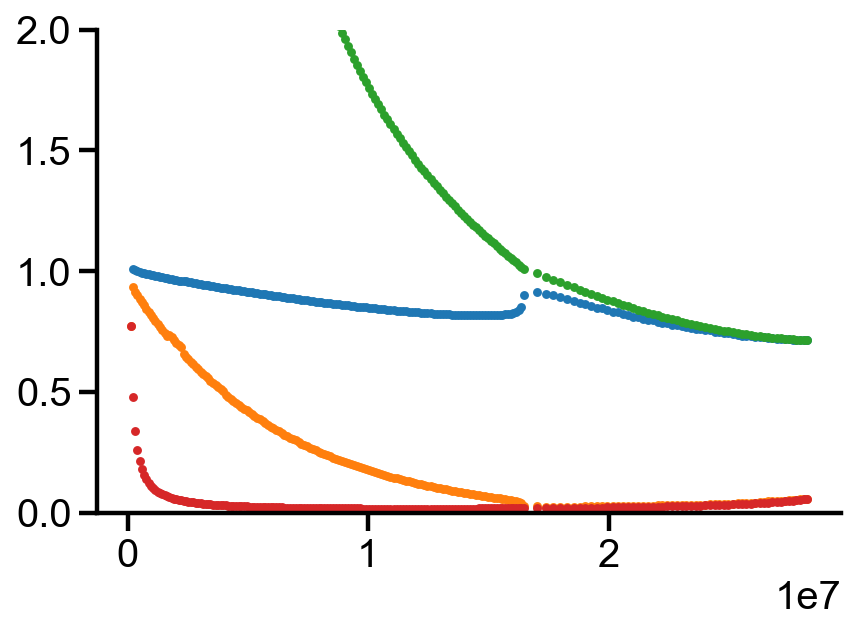

In [38]:
plt.plot(pr_P[0, :], pr_phi_v1[0, :], '.')
plt.plot(pr_P[0, :], pr_phi_v2[0, :], '.')
plt.plot(pr_P[0, :], pr_phi_l1[0, :], '.')
plt.plot(pr_P[0, :], pr_phi_l2[0, :], '.')
plt.ylim(0, 2)

In [22]:
pr_v_v[:, 1]

array([0.01152377, 0.01152842, 0.01153307, 0.0115424 , 0.01171438])

In [23]:
k12_sim

array([0.   , 0.025, 0.05 , 0.1  , 1.   ])

In [24]:
pr_P[:, 1]

array([217216.6928621 , 217202.55316504, 217188.36939575, 217159.86883627,
       216614.98058953])

In [25]:
pr_y1[:, 0]

array([0.00100848, 0.00113448, 0.0009912 , 0.0009752 , 0.00100075])